In [ ]:

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Input, Dropout, Add, ZeroPadding2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/585/Project 02 - Data.csv')

# Convert the pixel strings into numpy arrays
pixels = []
for p in df.pixels:
    pixels.append(np.fromstring(p, sep=' '))
df['pixels'] = pixels
pixels = None  # Release memory

# Create a dataframe containing only those rows for which age & gender predictions need to be made
df_predict = df[pd.isnull(df.age) == True].copy()

# Remove all incomplete rows from the 'df' dataframe
df = df[pd.isnull(df.age) == False].copy()

# Split the data into X and y
X_pixels = df['pixels']
y_age = df['age']
y_gender = df['gender']

# Split the data into training and testing sets for age and gender
X_pixels_train, X_pixels_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    X_pixels, y_age, y_gender, test_size=0.05, random_state=42)

# Convert the pixel values to tensors and normalize (assuming grayscale images)
X_pixels_train = tf.convert_to_tensor(np.array(list(X_pixels_train)).reshape(-1, 48, 48, 1) / 255.0)
X_pixels_test = tf.convert_to_tensor(np.array(list(X_pixels_test)).reshape(-1, 48, 48, 1) / 255.0)
#full data set
X_pixels_total = tf.convert_to_tensor(np.array(list(X_pixels)).reshape(-1, 48, 48, 1) / 255.0)


In [ ]:
y_age.shape

(8500,)

In [ ]:

inputs = tf.keras.Input(shape=(48, 48, 1))
#x = data_augmentation(inputs)

# 1st Convolutional block
x = tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(l2=0.1))(inputs) 
x = tf.keras.layers.BatchNormalization()(x)

#x = Dropout(0.2)(x)
# 2nd Convolutional block with residual connection
res = tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(2, 2), padding='same')(x) 
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2=0.1))(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2=0.1))(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = Dropout(0.2)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = Add()([res, x]) # Adding the residual connection
# x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
# 3rd Convolutional block
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(l2=0.1))(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
#x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=l2(l2=0.1))(x)
#x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(l2=0.1))(x)
#x = tf.keras.layers.Dense(units=128, activation='relu')(x)
#x = Dropout(0.5)(x)

gender = tf.keras.layers.Dense(units=1, activation='sigmoid', name='gender')(x)
age = tf.keras.layers.Dense(units=1, activation='relu', name='age')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=[gender, age])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss={'gender': 'binary_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'age': 'mae'})


# Add learning rate reduction and early stopping callbacks
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
]

# history = model.fit(train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y)),
#                     epochs=50,
#                     callbacks=callbacks_list, validation_data=val_dataset)

history = model.fit(X_pixels_total, {'age': y_age, 'gender': y_gender},
                    epochs=73, batch_size=12,
                    callbacks=callbacks_list)
#, validation_split=0.10
# Evaluate the model
loss, gender_loss, age_loss, gender_accuracy, age_mae = model.evaluate(X_pixels_total, {'age': y_age, 'gender': y_gender})

# Print the evaluation results
print('Loss: {:.4f}'.format(loss))
print('Gender Loss: {:.4f}'.format(gender_loss))
print('Age Loss: {:.4f}'.format(age_loss))
print('Gender Accuracy: {:.4f}'.format(gender_accuracy))
print('Age MAE: {:.4f}'.format(age_mae))


In [ ]:
 # Evaluate the model on the validation data
val_loss, val_gender_loss, val_age_loss, val_gender_accuracy, val_age_mae = model.evaluate(X_pixels_test, {'age': y_age_test, 'gender': y_gender_test})

    # Print the validation results
print('Validation Loss: {:.4f}'.format(val_loss))
print('Validation Gender Loss: {:.4f}'.format(val_gender_loss))
print('Validation Age Loss: {:.4f}'.format(val_age_loss))
print('Validation Gender Accuracy: {:.4f}'.format(val_gender_accuracy))
print('Validation Age MAE: {:.4f}'.format(val_age_mae))

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/585/Project 02 - Data.csv')

# Convert the pixel strings into numpy arrays
pixels = []
for p in df.pixels:
    pixels.append(np.fromstring(p, sep=' '))
df['pixels'] = pixels
pixels = None  # Release memory

# Create a dataframe containing only those rows for which age & gender predictions need to be made
df_predict = df[pd.isnull(df.age) == True].copy()


X_pixels_predict = df_predict['pixels']
X_pixels_predict = tf.convert_to_tensor(np.array(list(X_pixels_predict)).reshape(-1, 48, 48, 1) / 255.0)

In [ ]:
predictions = model.predict(X_pixels_predict)


# Create a DataFrame to hold the predictions
df_Predictions = pd.DataFrame({'gender': predictions[0].flatten(), 'age': predictions[1].flatten()})

# Print or output the DataFrame
print(df_Predictions)

In [ ]:
df_Predictions['gender'] = df_Predictions['gender'].apply(lambda x: 1 if x > 0.5 else 0)

In [ ]:
df_predict['row_position'] = -1
df_Predictions['row_position'] = -1

# Perform join 
df_combined = pd.concat([df_predict['id'], df_Predictions], axis=1)

# Remove "row_position" column
df_combined.drop('row_position', axis=1, inplace=True)

# Display data frame
print(df_combined)

          id  gender        age
8500  8501.0     NaN        NaN
8501  8502.0     NaN        NaN
8502  8503.0     NaN        NaN
8503  8504.0     NaN        NaN
8504  8505.0     NaN        NaN
...      ...     ...        ...
1495     NaN     0.0   5.974655
1496     NaN     1.0  38.895748
1497     NaN     0.0  36.105755
1498     NaN     0.0  37.037350
1499     NaN     0.0  22.848570

[3000 rows x 3 columns]


In [ ]:
df_combined[['id', 'age', 'gender']].to_csv('Safai, Cameron222.csv', index=False)

Original shape of T_pixels: (1,)
Reshaped T_pixels shape: (1, 48, 48, 1)


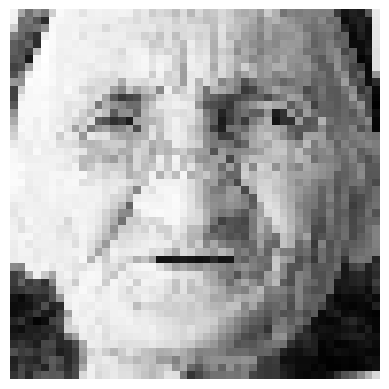

In [ ]:
from matplotlib import pyplot as plt

T_pixels = df['pixels'][df['id'] == 8514]
T_pixels = T_pixels / 255
img_width, img_height = 48, 48  


print("Original shape of T_pixels:", T_pixels.shape)

try:
    T_pixels = np.array([x.reshape(img_width, img_height, 1) for x in T_pixels])
    print("Reshaped T_pixels shape:", T_pixels.shape)


except ValueError as e:
    print("Error occurred:", e)

img_width, img_height = 48, 48  
T_pixels = T_pixels.reshape(img_height, img_width)

# Display the image
plt.imshow(T_pixels, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
df_Predictions